In [1]:
import transformers
from transformers import AutoModelForQuestionAnswering, AutoModel, AutoConfig, get_linear_schedule_with_warmup
from transformers.optimization import AdamW
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from pathlib import Path
import os
from itertools import compress
import utils

In [2]:
from torch.utils.data import DataLoader
from apex.optimizers.fused_lamb import FusedLAMB as Lamb
from fairseq import criterions 
from functools import partial
from tokenizers import BertWordPieceTokenizer, ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from fastai.core import *
from fastai.text import *

In [3]:
# def seed_everything(seed_value):
#     random.seed(seed_value)
#     np.random.seed(seed_value)
#     torch.manual_seed(seed_value)
#     os.environ['PYTHONHASHSEED'] = str(seed_value)
    
#     if torch.cuda.is_available(): 
#         torch.cuda.manual_seed(seed_value)
#         torch.cuda.manual_seed_all(seed_value)
#         torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = True

# seed = 42
# seed_everything(seed)

In [3]:
path = Path.cwd() 

In [4]:
file_dir = Path.cwd()/'data'
train_df = pd.read_csv(file_dir/'train.csv')
# train_df = pd.read_csv(file_dir/'extended_train.csv')
train_df['text'] = train_df['text'].apply(lambda x: str(x))
train_df['sentiment'] = train_df['sentiment'].apply(lambda x: str(x))
train_df['selected_text'] = train_df['selected_text'].apply(lambda x: str(x))

In [5]:
max_len = 128
bs = 64
# Roberta prefixes initial tokens with a space
tokenizer = transformers.RobertaTokenizerFast('input/roberta-base/vocab.json', 'input/roberta-base/merges.txt',
                                  lowercase=True,add_prefix_space=True).tokenizer

In [25]:
b = torch.LongTensor(a.ids)[None]
b = b.cuda()

In [35]:
len(pt_model(b)[2])

13

In [6]:
def preprocess(sentiment, tweet, selected, tokenizer, max_len):
    _input = tokenizer.encode(sentiment, tweet)
    _span = tokenizer.encode(selected, add_special_tokens=False)
    
    len_span = len(_span.ids)
    start_idx = None
    end_idx = None
    
    for ind in (i for i, e in enumerate(_input.ids) if e == _span.ids[0]):
        if _input.ids[ind: ind + len_span] == _span.ids:
            start_idx = ind
            end_idx = ind + len_span - 1
            break
    
    # Handles cases where tokenizing input & span separately produces different outputs
    if not start_idx:
        idx0 = tweet.find(selected)
        idx1 = idx0 + len(selected)
        
        char_targets = [0] * len(tweet)
        if idx0 != None and idx1 != None:
            for ct in range(idx0, idx1):
                char_targets[ct] = 1
                
        tweet_offsets = _input.offsets[4:-1]
        
        target_idx = []
        for j, (offset1, offset2) in enumerate(tweet_offsets):
            if sum(char_targets[offset1: offset2]) > 0:
                target_idx.append(j)
                
        start_idx, end_idx = target_idx[0] + 4 , target_idx[-1] + 4
        
    _input.start_target = start_idx
    _input.end_target = end_idx
    _input.tweet = tweet
    _input.sentiment = sentiment
    _input.selected = selected
    
    _input.pad(max_len)
    
    return _input

In [7]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss    

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return torch.lerp(nll, loss/c, self.ε) 

In [8]:
class TweetDataset(Dataset):
    def __init__(self, dataset):
        self.df = dataset
        
    def __getitem__(self, idx):
        sentiment, tweet, selected = (self.df[col][idx] for col in ['sentiment', 'text', 'selected_text'])
        _input = preprocess(sentiment, tweet, selected, tokenizer, max_len)
        
        
        xb = [torch.LongTensor(_input.ids),
              torch.LongTensor(_input.attention_mask),
              np.array(_input.offsets)]
        
        yb = [torch.tensor(_input.start_target), torch.tensor(_input.end_target)]

        return xb, yb     

    def __len__(self):
        return len(self.df)

In [9]:
config = AutoConfig.from_pretrained('roberta-base')
config.output_hidden_states = True
pt_model = AutoModel.from_pretrained('roberta-base', config = config)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /home/jack/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
INFO:transformers.configuration_utils:Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps":

In [10]:
class SpanModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = pt_model
        self.drop_out = nn.Dropout(0.1)
        self.qa_outputs = nn.Linear(768 * 2, 2) # update hidden size

    # could pass offsets here and not use - can grab in last_input
    def forward(self, input_ids, attention_mask, offsets = None):
        
        _, _, hidden_states = self.model(input_ids, attention_mask=attention_mask)

        out = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)
        out = self.drop_out(out)
        logits = self.qa_outputs(out)
        
        start_logits, end_logits = logits.split(1, dim=-1)
        
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [11]:
class CELoss(Module):
    def __init__(self, loss_fn = nn.CrossEntropyLoss()): 
        self.loss_fn = loss_fn
    def forward(self, inputs, start_targets, end_targets):
        start_logits, end_logits = inputs # assumes tuple input
        
        logits = torch.cat([start_logits, end_logits]).contiguous()
        
        targets = torch.cat([start_targets, end_targets]).contiguous()
        
        return self.loss_fn(logits, targets)

In [12]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [13]:
# Note that validation ds is by default not shuffled in fastai - so indexing like this will work for Callback
# https://forums.fast.ai/t/how-to-set-shuffle-false-of-train-and-val/33730

class JaccardScore(Callback):
    "Stores predictions and targets to perform calculations on epoch end."
    def __init__(self, valid_ds): 
        self.valid_ds = valid_ds
        self.context_text = valid_ds.df.text
        self.answer_text = valid_ds.df.selected_text
        
    def on_epoch_begin(self, **kwargs):
        self.jaccard_scores = []  
        self.valid_ds_idx = 0
        
        
    def on_batch_end(self, last_input:Tensor, last_output:Tensor, last_target:Tensor, **kwargs):
              
        input_ids = last_input[0]
        offsets = last_input[2]

        start_logits, end_logits = last_output
        
        # for id in batch of ids
        for i in range(len(input_ids)):
            
            _offsets = offsets[i]
            start_idx, end_idx = torch.argmax(start_logits[i]), torch.argmax(end_logits[i])
            _answer_text = self.answer_text[self.valid_ds_idx]
            original_start, original_end = _offsets[start_idx][0], _offsets[end_idx][1]
            pred_span = self.context_text[self.valid_ds_idx][original_start : original_end]
                
            score = jaccard(pred_span, _answer_text)
            self.jaccard_scores.append(score)

            self.valid_ds_idx += 1
            
    def on_epoch_end(self, last_metrics, **kwargs):        
        res = np.mean(self.jaccard_scores)
        return add_metrics(last_metrics, res)

In [241]:
def model_split_func(m): 
    "4 layer groups"
    n = len(m.sequence_model.encoder.layer)//2
    return (m.sequence_model.embeddings, m.sequence_model.encoder.layer[:n], m.sequence_model.encoder.layer[n:], m.head)

In [242]:
def model_split_func(m): 
    n = len(m.sequence_model.encoder.layer) - 5
    return (m.sequence_model.embeddings, m.sequence_model.encoder.layer[n], m.head)

In [18]:
from fastai.callbacks import *

def new_on_train_begin(self, **kwargs:Any)->None:
    "Initializes the best value."
    if not hasattr(self, 'best'):
        self.best = float('inf') if self.operator == np.less else -float('inf')

SaveModelCallback.on_train_begin = new_on_train_begin

In [17]:
# ext_df = pd.read_csv(file_dir/'extended_train.csv')

In [23]:
from fastai.callbacks import *
### Simple no jaccard test
from sklearn.model_selection import train_test_split

tr_df, val_df = train_test_split(train_df[train_df['sentiment']!='neutral'], test_size = 0.2, random_state = 42)
tr_df.reset_index(drop=True, inplace = True)
val_df.reset_index(drop=True, inplace = True)

train_ds, valid_ds = [TweetDataset(i) for i in [tr_df,val_df]]
data = DataBunch.create(train_ds, valid_ds,bs = bs)
loss_fn = partial(CELoss, LabelSmoothingCrossEntropy())

# LEARNER
model = SpanModel()
learner = Learner(data, model, loss_func = loss_fn(), opt_func = Lamb, metrics = [JaccardScore(valid_ds)])
# learner.split(model_split_func)
# learner.to_fp16() 

# # CALLBACKS
early_stop_cb = EarlyStoppingCallback(learner, monitor='jaccard_score',mode='max',patience=2)
# save_model_cb = SaveModelCallback(learner,every='improvement',monitor='jaccard_score',name=f'{MODEL_TYPE}-qa-finetune')
# csv_logger_cb = CSVLogger(learner, f"training_logs_{foldnum}", True)

In [25]:
learner.lr_find()

epoch,train_loss,valid_loss,jaccard_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


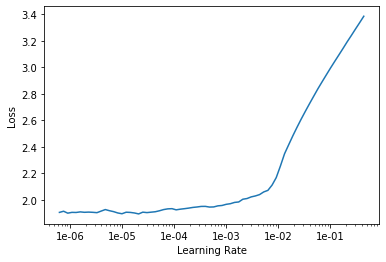

In [26]:
learner.recorder.plot()

In [24]:
lr = 3e-5

# Last Param Group
# learner.freeze_to(3);
learner.fit_one_cycle(4, lr, pct_start=0.4, div_factor=50, wd=0.01, callbacks=[early_stop_cb])

epoch,train_loss,valid_loss,jaccard_score,time
0,3.257074,2.709747,0.351104,05:17
1,2.156778,2.029411,0.482501,05:17
2,1.968697,1.918399,0.516633,05:18
3,1.924063,1.907714,0.521629,05:18


In [27]:
learner.fit_one_cycle(2, 1e-05, pct_start=0.4, div_factor=50, 
                      wd=0.01, callbacks=[early_stop_cb])

epoch,train_loss,valid_loss,jaccard_score,time
0,1.894800,1.900829,0.525189,05:25
1,1.906958,1.890589,0.528602,05:31


In [28]:
learner.save('fastai_model_r')